In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import scipy.optimize as op

# Programming Exercise 4: Neural Networks Learning

## 1. Neural Networks

In the previous programming assignment, we implemented feedforward propagation for neural networks and used it to predict handwritten digits with the pre-trained weights provided. In this exercise, we will implement the backpropagation algorithm to learn the parameters for the neural network.

### 1.1 Visualizing the data

In [2]:
# Read .mat file
data = io.loadmat('ex4data1.mat')

# Separate into X and y values
X = data["X"]
y = data["y"]

The data set for this exercise is the same as the one in Programming Exercise 3. There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector $y$ that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped
the digit zero to the value ten.

Finally, we visualize a subset of the training set by selecting 100 random rows in matrix $X$ and mapping each one to a 20 pixel by 20 pixel grayscale image. The result is the figure below.

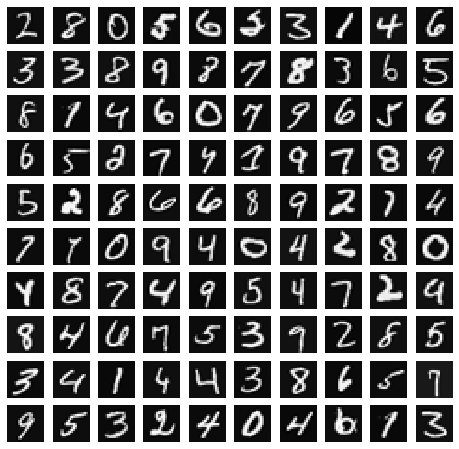

In [3]:
# Plot digits
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize = (8, 8))
for i in range(0, 100, 10):
    for j in range(10):
        # Choose random digit/row from X
        digit = X[np.random.randint(0, X.shape[0] + 1), :]
        
        # Plot digit
        ax[int(i/10),j].imshow(digit.reshape(20, 20, order = "F"), cmap = "gray")
        ax[int(i/10),j].axis("off")

### 1.2 Model representation

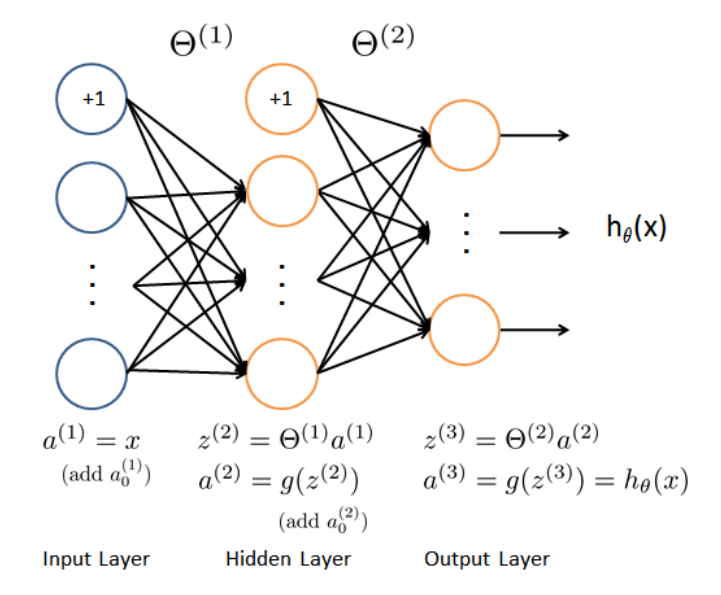

Our neural network is shown in the figure above. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 $\times$ 20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1).

### 1.3 Feedfoward and cost function

Recall that the cost function for the neural network (without regularization) is

$J(\theta) = \frac{1}{m} \sum_{i = 1}^{m} \sum_{k = 1}^{K} \left[ −y_{k}^{(i)} \log{((h_{\Theta}(x^{(i)}))_{k})} − (1 − y_{k}^{(i)}) \log{(1 - (h_{\Theta}(x^{(i)}))_{k})} \right]$

where $h_{θ}(x^{(i)})$ is computed as shown in the figure above and $K$ = 10 is the total number of possible labels. Note that $h_{θ}(x^{(i)}))_{k} = a_{k}^{(3)}$ is the activation (output value) of the $k$-th output unit. Also, recall that whereas the original labels (in the variable $y$) were 0, 1, $\ldots$, 9, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that $y$ should be reconfigured as shown below.

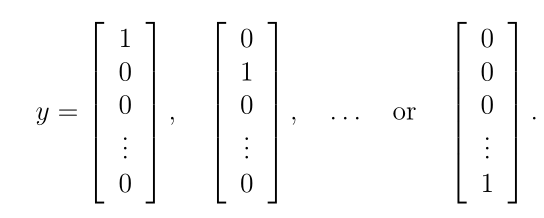

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ should be a 10-dimensional
vector with $y_{5}$ = 1, and the other elements equal to 0.

`nnCostFunction` below implements forward propagation and computes for the cost associated with a neural network with the architecture shown above.

In [4]:
# sigmoid computes the sigmoid of each value of x (x can be a matrix, vector or scalar).
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
#nnCostFunction implements the neural network cost function for a two layer
#neural network which performs classification

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, (hidden_layer_size + 1)))
    
    # Initialize variables
    num_examples, num_features = X.shape
    J = 0

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Implement feedforward algorithm
    a1 = X                                           # input layer
    z2 = a1 @ Theta1.T
    a2 = sigmoid(z2)                                 # hidden layer
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2))
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)                                 # output layer/prediction
    
    # Perform one-hot encoding
    y_onehot = np.squeeze(np.eye(num_labels)[y - 1])
   
    # Compute for cost
    J = (1 / num_examples) * np.sum(-y_onehot * np.log(a3) - (1 - y_onehot) * np.log(1 - a3))
    
    return J

For `nn_params`, we have been provided with a set of pre-trained network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$). These are stored in `ex4weights.mat` and will be loaded into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [6]:
# Load the weights...
data_weights = io.loadmat('ex4weights.mat')

# ...into Theta1 and Theta2
Theta1 = data_weights["Theta1"]
Theta2 = data_weights["Theta2"]

In [7]:
#TESTS

# Initialize variables
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10   
nn_params = np.append(Theta1.flatten(),Theta2.flatten())

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y)
print("Cost at parameters (loaded from ex4weights): ", J)
print("This value should be about 0.287629.")

Cost at parameters (loaded from ex4weights):  0.2876291651613189
This value should be about 0.287629.


### 1.4 Regularized cost function

The cost function for neural networks with regularization is given by

$J(\theta) = \frac{1}{m} \sum_{i = 1}^{m} \sum_{k = 1}^{K} \left[ −y_{k}^{(i)} \log{((h_{θ}(x^{(i)}))_{k})} − (1 − y_{k}^{(i)}) \log{(1 - (h_{θ}(x^{(i)}))_{k})} \right] + \frac{\lambda}{2m} \left[ \sum_{j = 1}^{25} \sum_{k = 1}^{400} (\Theta_{j,k}^{(1)})^{2} + \sum_{j = 1}^{10} \sum_{k = 1}^{25} (\Theta_{j,k}^{(2)})^{2} \right] $

We extend `nnCostFunction` to account for a regularization parameter. This implementation is shown below.

In [8]:
#nnCostFunction implements the neural network cost function for a two layer
#neural network which performs classification

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, (hidden_layer_size + 1)))
    
    # Initialize variables
    num_examples, num_features = X.shape
    J = 0

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Implement feedforward algorithm
    a1 = X                                           # input layer
    z2 = a1 @ Theta1.T
    a2 = sigmoid(z2)                                 # hidden layer
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2))
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)                                 # output layer/prediction
    
    # Perform one-hot encoding
    y_onehot = np.squeeze(np.eye(num_labels)[y - 1])
   
    # Compute for cost
    J = (1 / num_examples) * np.sum(-y_onehot * np.log(a3) - (1 - y_onehot) * np.log(1 - a3))
    J_reg = lmbda / (2 * num_examples) * (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2))
    J += J_reg
    
    return J

In [9]:
#TESTS

# Initialize variables
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10   
nn_params = np.append(Theta1.flatten(),Theta2.flatten())
lmbda = 1                # regularization parameter

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
print("Cost at parameters (loaded from ex4weights): ", J)
print("This value should be about 0.383770.")

Cost at parameters (loaded from ex4weights):  0.38376985909092365
This value should be about 0.383770.


## 2. Backpropagation

We can now implement the backpropagation algorithm to compute the gradient for the neural network cost function.

### 2.1 Sigmoid gradient

We will first implement the sigmoid gradient function. The gradient for the sigmoid function can be
computed as

$g'(z) = \frac{d}{dz} g(z) = g(z)(1 - g(z))$

where

$g(z) = \frac{1}{1 + e^{-z}}$

In [10]:
#sigmoidGradient returns the gradient of the sigmoid function evaluated at z
def sigmoidGradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [11]:
#TESTS

g = sigmoidGradient(0)
print("Sigmoid gradient evaluated at 0: ", g)
print("This value should be about 0.25.")

Sigmoid gradient evaluated at 0:  0.25
This value should be about 0.25.


### 2.2 Random initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(1)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. It is suggested that we use $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$, which in our case amounts to 0.12. This range of values ensures that the parameters are kept small and makes the learning more efficient.

In [12]:
# randInitializeWeights randomly initializes the weights of a layer with L_in
# incoming connections and L_out outgoing connections
def randInitializeWeights(L_in, L_out):
    
    # Compute for epsilon
    epsilon = np.sqrt(6) / np.sqrt(L_in + L_out)
    
    # Generate an L_out x L_in + 1 matrix where the values lie within the range [-epsilon, epsilon]
    W = np.random.rand(L_out, L_in + 1) * (2 * epsilon) - epsilon
    
    return W

### 2.3 Backpropagation

Now, we will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_{\Theta}(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_{j}^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_{j}^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_{j}^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.

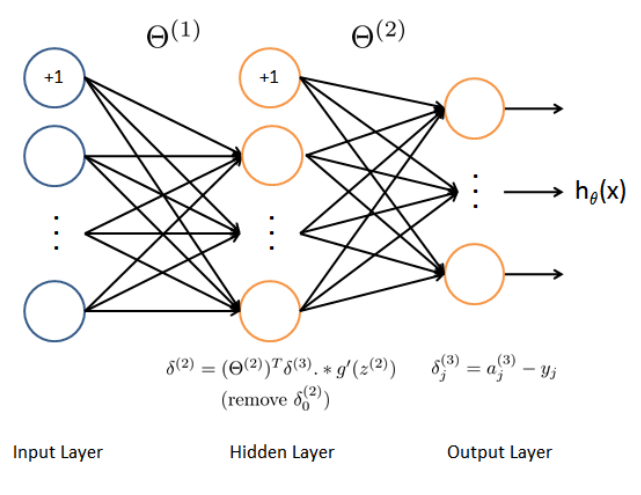

In detail, here is the backpropagation algorithm (also depicted in the figure above). Steps 1 to 4 should be implemented in a loop that processes one example at a time. Concretely, steps 1-4 below should be placed inside a for-loop for $t$ = 1 to m, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by m to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t$-th training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. 

2. For each output unit $k$ in layer 3 (the output layer), set

$\delta_{k}^{(3)} = (a_{k}^{(3)} − y_{k}),$

where $y_{k} \in {0, 1}$ indicates whether the current training example belongs to class $k$ ($y_{k}$ = 1), or if it belongs to a different class ($y_{k}$ = 0).

3. For the hidden layer $l$ = 2, set

$\delta^{(2)} = (\Theta^{(2)})^{T} \delta^{(3)} .* g'(z^{(2)})$

4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_{0}^{(2)}$.

$\Delta^{(l)} = \Delta^{(l)} + \delta^{(l + 1)}(a^{(l)})^{T}$

5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$.

$\frac{\partial}{\partial \Theta_{ij}^{l}} J(\Theta) = D_{ij}^{l} = \frac{1}{m} \Delta_{ij}^{(l)}$

We extend `nnCostFunction` to calculate gradients using backpropagation. This implementation is shown below.

In [13]:
#nnCostFunction implements the neural network cost function for a two layer
#neural network which performs classification

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, (hidden_layer_size + 1)))
    
    # Initialize variables
    num_examples, num_features = X.shape
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Implement feedforward algorithm
    a1 = X                                           # input layer
    z2 = a1 @ Theta1.T
    a2 = sigmoid(z2)                                 # hidden layer
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2))
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)                                 # output layer/prediction
    
    # Perform one-hot encoding
    y_onehot = np.squeeze(np.eye(num_labels)[y - 1])
   
    # Compute for cost
    J = (1 / num_examples) * np.sum(-y_onehot * np.log(a3) - (1 - y_onehot) * np.log(1 - a3))
    J_reg = lmbda / (2 * num_examples) * (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2))
    J += J_reg
    
    # Calculate for gradients using backpropagation
    for t in range(num_examples):
        # Step 1: Implement feedforward algorithm
        a1_t = a1[t, :][:, np.newaxis]     # 401 x 1
        z2_t = Theta1 @ a1_t               
        z2_t = np.vstack((1, z2_t))        # 26 x 1
        a2_t = sigmoid(z2_t)               # 26 x 1
        z3_t = Theta2 @ a2_t               # 10 x 1
        a3_t = sigmoid(z3_t)               # 10 x 1
        
        # Step 2: Calculate delta_3
        delta_3 = a3_t - y_onehot[t, :][:, np.newaxis]    # 10 x 1
        
        # Step 3: Calculate delta_2
        delta_2 = (Theta2.T @ delta_3) * sigmoidGradient(z2_t)   # 26 x 1
        
        # Step 4: Accumulate the gradient
        Theta1_grad += delta_2[1:] @ a1_t.T     # 25 x 401
        Theta2_grad += delta_3 @ a2_t.T         # 10 x 26
        
    # Divide grads by m
    Theta1_grad = Theta1_grad / num_examples
    Theta2_grad = Theta2_grad / num_examples
    
    return J, Theta1_grad, Theta2_grad

### 2.4 Regularized Neural Networks

After successfully implementing the backpropagation algorithm, we will add regularization to the gradient. To account for regularization, we can add this as an additional term after computing the gradients using backpropagation. Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

for j = 0:
$\frac{\partial}{\partial \Theta_{ij}^{l}} J(\Theta) = D_{ij}^{l} = \frac{1}{m} \Delta_{ij}^{(l)}$

for j $\geq$ 1:
$\frac{\partial}{\partial \Theta_{ij}^{l}} J(\Theta) = D_{ij}^{l} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)}$

We extend `nnCostFunction` to calculate regularized gradients using backpropagation. This implementation is shown below.

In [14]:
#nnCostFunction implements the neural network cost function for a two layer
#neural network which performs classification

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, (hidden_layer_size + 1)))
    
    # Initialize variables
    num_examples, num_features = X.shape
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Implement feedforward algorithm
    a1 = X                                           # input layer
    z2 = a1 @ Theta1.T
    a2 = sigmoid(z2)                                 # hidden layer
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2))
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)                                 # output layer/prediction
    
    # Perform one-hot encoding
    y_onehot = np.squeeze(np.eye(num_labels)[y - 1])
   
    # Compute for cost
    J = (1 / num_examples) * np.sum(-y_onehot * np.log(a3) - (1 - y_onehot) * np.log(1 - a3))
    J_reg = lmbda / (2 * num_examples) * (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2))
    J += J_reg
    
    # Calculate for gradients using backpropagation
    for t in range(num_examples):
        # Step 1: Implement feedforward algorithm
        a1_t = a1[t, :][:, np.newaxis]     # 401 x 1
        z2_t = Theta1 @ a1_t               
        z2_t = np.vstack((1, z2_t))        # 26 x 1
        a2_t = sigmoid(z2_t)               # 26 x 1
        z3_t = Theta2 @ a2_t               # 10 x 1
        a3_t = sigmoid(z3_t)               # 10 x 1
        
        # Step 2: Calculate delta_3
        delta_3 = a3_t - y_onehot[t, :][:, np.newaxis]    # 10 x 1
        
        # Step 3: Calculate delta_2
        delta_2 = (Theta2.T @ delta_3) * sigmoidGradient(z2_t)   # 26 x 1
        
        # Step 4: Accumulate the gradient
        Theta1_grad += delta_2[1:] @ a1_t.T     # 25 x 401
        Theta2_grad += delta_3 @ a2_t.T
        
    # Divide grads by m
    Theta1_grad = Theta1_grad / num_examples
    Theta2_grad = Theta2_grad / num_examples
    
    # Add regularization terms
    Theta1_grad = Theta1_grad + (lmbda / num_examples) * np.hstack((np.zeros((Theta1.shape[0], 1)), Theta1[:, 1:]))
    Theta2_grad = Theta2_grad + (lmbda / num_examples) * np.hstack((np.zeros((Theta2.shape[0], 1)), Theta2[:, 1:]))
    
    return J, Theta1_grad, Theta2_grad

### 2.5 Learning Parameters using Gradient Descent

After successfully implementing the neural network cost function and gradient computation, the next step is to use gradient descent to learn a good set parameters. `gradientDescent` below implements this.

In [15]:
# gradientDescent performs gradient descent to learn theta.
def gradientDescent(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, alpha, lmbda):
    # Initialize values
    J_history = np.zeros((num_iters, 1))
    
    # Unfold Theta1 and Theta2 parameters from params
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, (hidden_layer_size + 1)))

    # Perform gradient descent
    for i in range(num_iters):
        # Compute for cost and grad
        J, Theta1_grad, Theta2_grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
        
        # Update Theta1 and Theta2
        Theta1 -= alpha * Theta1_grad
        Theta2 -= alpha * Theta2_grad
        
        # Repack Theta1 and Theta2 to params
        nn_params = np.append(Theta1.flatten(), Theta2.flatten())
        
        # Save the cost of J in every iteration
        J_history[i, :] = J

    # Unfold final X and Theta parameters from params
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, (hidden_layer_size + 1)))

    return Theta1, Theta2, J_history

Now we can implement gradient descent to learn our own $\Theta^{(1)}$ and $\Theta^{(2)}$

In [16]:
# Initialize Theta1 and Theta2
Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
nn_params = np.append(Theta1.flatten(), Theta2.flatten())

# Set regularization parameter, learning rate and number of iteraitions
lmbda = 1
alpha = 0.8
num_iters = 1000

# Perform gradient descent
Theta1_learned, Theta2_learned, J_history = gradientDescent(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, alpha, lmbda)

We now use the `predict` function from the earlier programming assignment. `predict` computes $h_{θ}(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $h_{θ}(x)_{k}$.

In [17]:
#predict predicts the label of an input given a trained neural network
def predict(Theta1, Theta2, X):
    # Initialize variables
    num_examples, num_features = X.shape

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Implement feedforward algorithm
    a1 = X
    a2 = sigmoid(a1 @ Theta1.T)
    
    # Add ones to the a2 matrix
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2))
    
    # Implement feedforward algorithm
    a3 = sigmoid(a2 @ Theta2.T)    
    
    # Get maximum "probability" for each training example
    return np.argmax(a3, axis = 1) + 1

In [18]:
# Make prediction
nnPred = predict(Theta1_learned, Theta2_learned, X)

# Compute for training accuracy
print("Training Set Accuracy: ", np.mean(nnPred == np.ravel(y)) * 100, "%")

Training Set Accuracy:  95.04 %


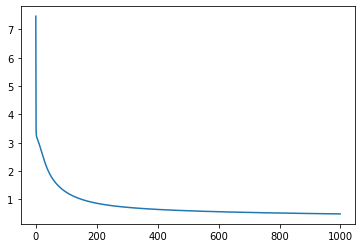

In [19]:
plt.plot(J_history)

We see that gradient descent was able to successfully learn the parameters for our neural network model, resulting in a 95.04% training accuracy. One can tweak the parameters using a cross-validation set for better performance on a testing set.